In [19]:
import utils
import sys
if 'utils' in sys.modules:
    del sys.modules['utils']
import utils
import torch
from tqdm import tqdm
import random
import time
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

checkpoint_path = 'weights/checkpoint_MLP_vector.pth'
RESUME_TRAINING = False

PRINT_IMG = True
VALIDATION_SPLIT = 0.7
AUGMENT_DATASET = False
AUGMENT_FRACTION = 0.3
TRANSFORM_DATASET = False

COSINE_ANNEALING = True
STEPLR = False
REDUCE_ON_PLATEAU = False

OPTIMIZER='SGD'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.01
MOMENTUM = 0.9
EPOCHS = 15

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 3

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [20]:
#train_dataset_imbalanced, _ = utils.create_train_dataset_imbalanced(TRANSFORM_DATASET, AUGMENT_DATASET)
#test_dataset_imbalanced, validation_dataset_imbalanced, _ = utils.create_test_dataset_imbalanced(VALIDATION_SPLIT)

In [21]:
#utils.plot_dataset_statistics(train_dataset_imbalanced, "Train Dataset Imbalanced")

In [22]:
#utils.plot_dataset_statistics(test_dataset_imbalanced, "Test Dataset Imbalanced")

In [23]:
#utils.plot_dataset_statistics(validation_dataset_imbalanced, "Validation Dataset Imbalanced")

In [24]:
train_dataset, train_dataset_raw = utils.create_train_dataset_MLP(TRANSFORM_DATASET, AUGMENT_DATASET, AUGMENT_FRACTION)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset_MLP(VALIDATION_SPLIT)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000
Dimensione del sottoinsieme aumentato: 18000


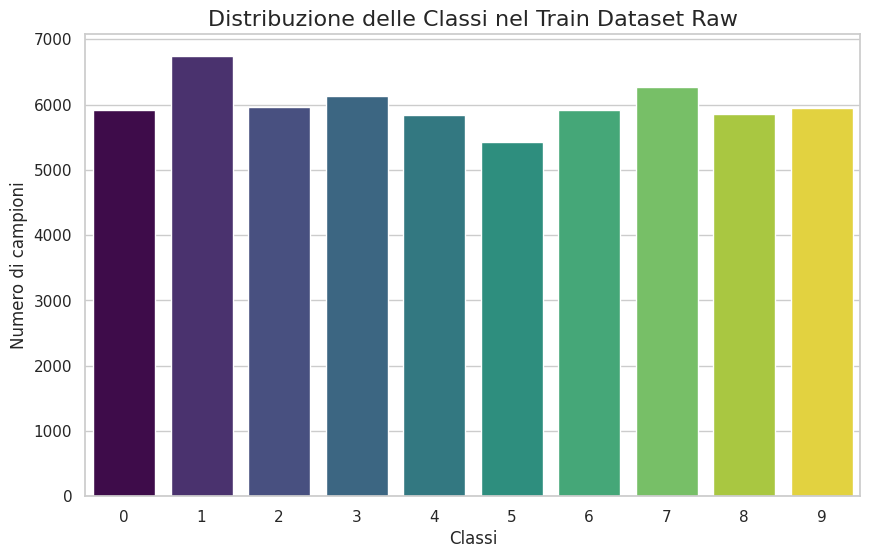

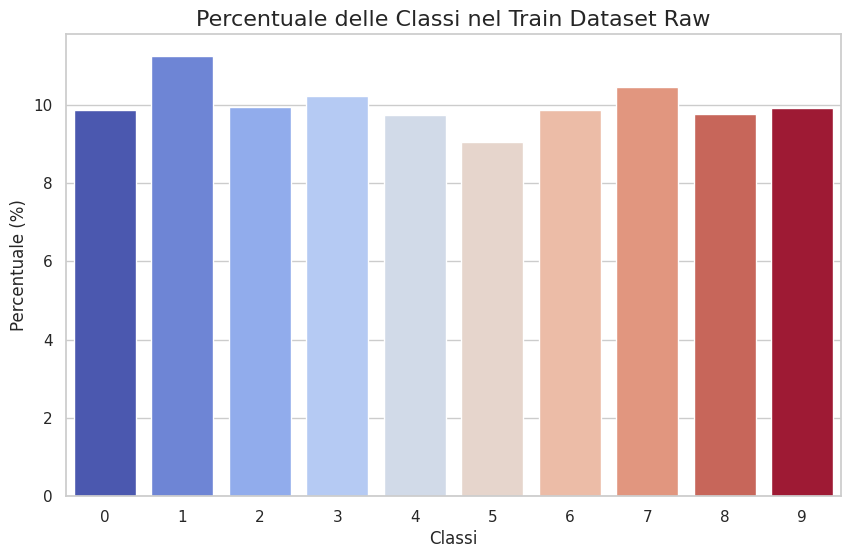

In [25]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 20000, 1: 20000, 2: 20000}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 0: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 2: 20000 campioni (33.33%)




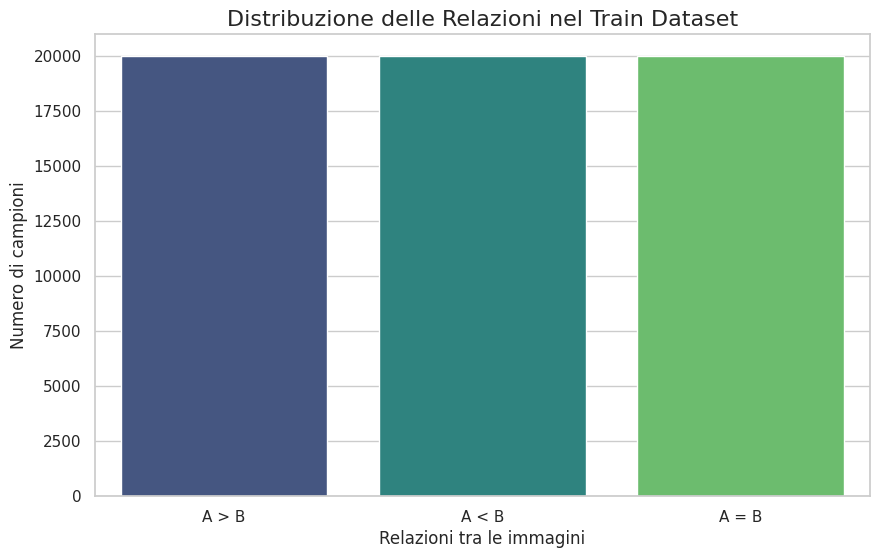

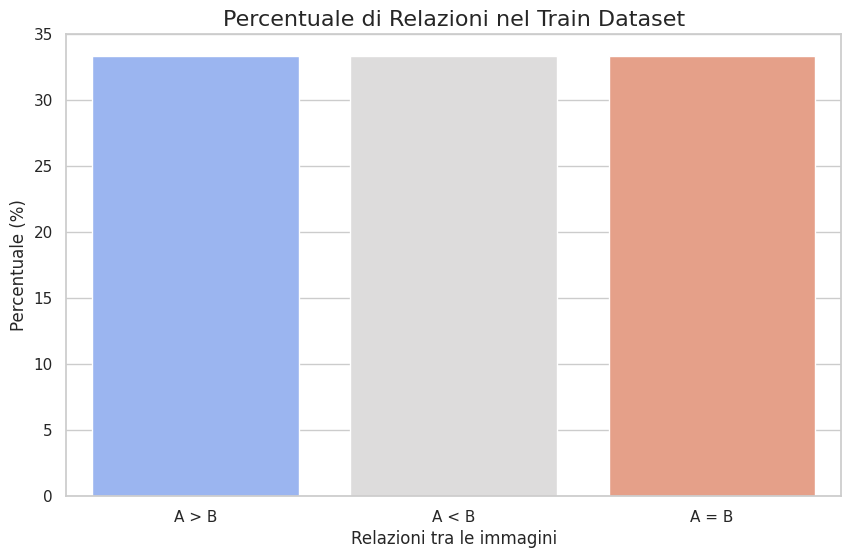

In [26]:
utils.plot_dataset_statistics_MLP(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 979, 0: 986, 1: 1035}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 2: 979 campioni (32.63%)
Relazione 0: 986 campioni (32.87%)
Relazione 1: 1035 campioni (34.50%)




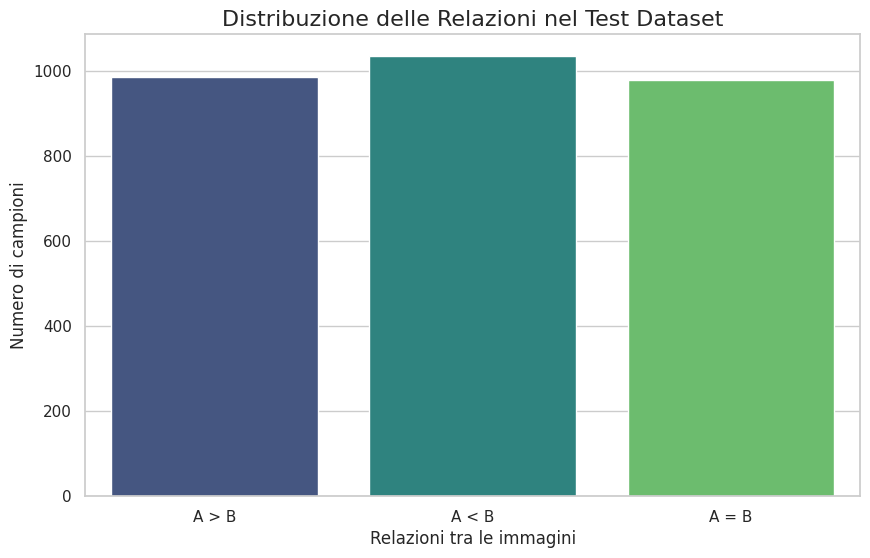

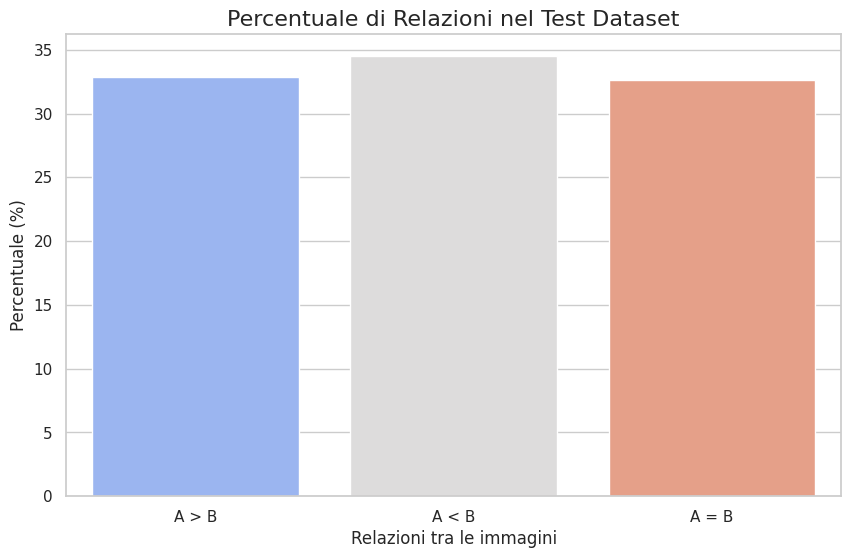

In [27]:
utils.plot_dataset_statistics_MLP(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 2347, 1: 2298, 2: 2354}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 0: 2347 campioni (33.53%)
Relazione 1: 2298 campioni (32.83%)
Relazione 2: 2354 campioni (33.63%)




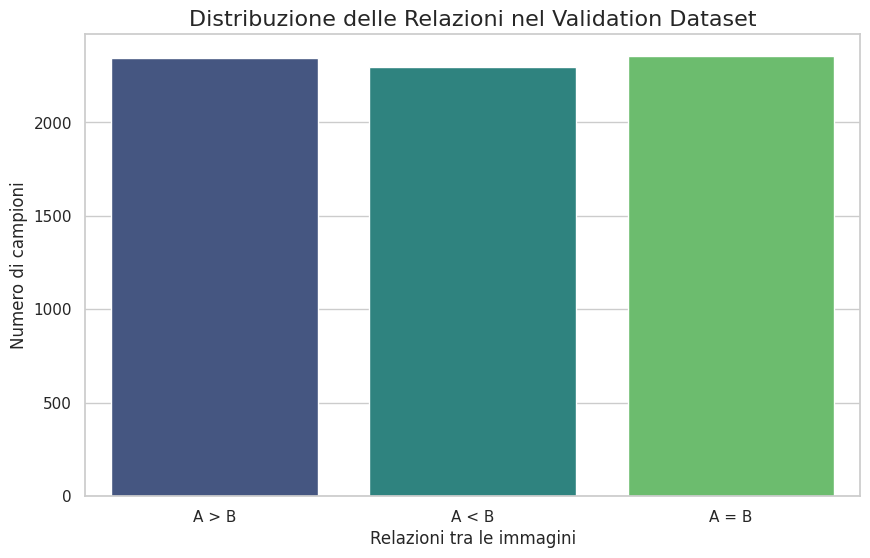

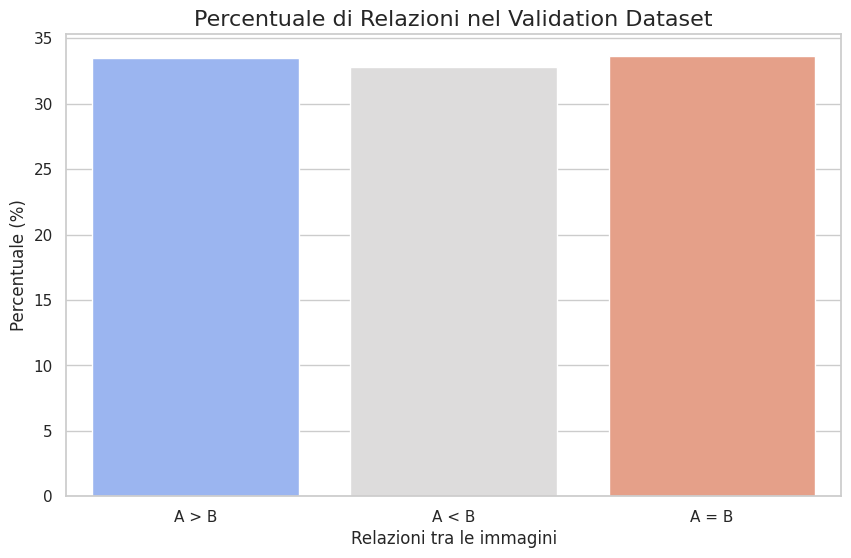

In [28]:
utils.plot_dataset_statistics_MLP(validation_dataset, dataset_name="Validation Dataset")

In [29]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [30]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [32]:
class NumberRecognitionCNN(nn.Module):
    def __init__(self):
        super(NumberRecognitionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # Singola immagine, quindi 1 canale
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


In [33]:
class ComparisonMLP(nn.Module):
    def __init__(self, feature_size):
        super(ComparisonMLP, self).__init__()
        self.fc1 = nn.Linear(feature_size * 2, 64)  # Prende 2 numeri in input
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)  # 3 classi (A > B, A < B, A = B)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output con 3 classi
        return x


In [34]:
class NumberComparisonModel(nn.Module):
    def __init__(self):
        super(NumberComparisonModel, self).__init__()
        self.cnn = NumberRecognitionCNN()  # Modello CNN per il riconoscimento dei numeri
        self.mlp = ComparisonMLP(feature_size=84)  # MLP per confrontare i due numeri

    def forward(self, img1: torch.Tensor, img2: torch.Tensor):
        # Riconoscimento del numero in ciascuna immagine
        features1 = self.cnn(img1)
        features2 = self.cnn(img2)

        combined_features = torch.cat((features1, features2), dim=1)

        comparison = self.mlp(combined_features)
        
        return comparison


In [35]:
model = NumberComparisonModel()

model.to(device)

# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()

if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

if REDUCE_ON_PLATEAU:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
elif COSINE_ANNEALING:
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
elif STEPLR:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7, verbose=True)

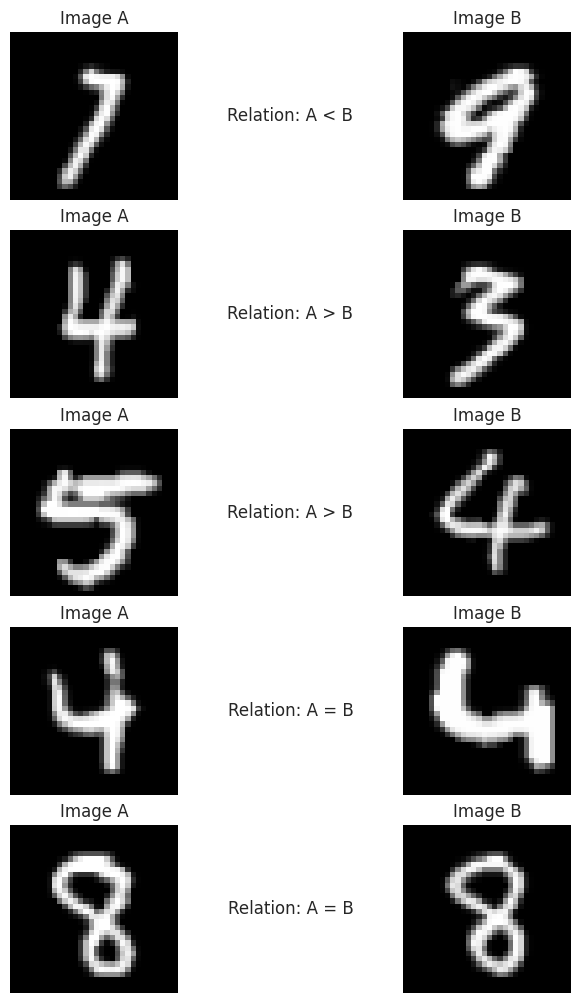

In [36]:
if OPTIMIZER == 'SGD':
    fileName = f"runs/logMLPvector_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/logMLPvector_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottiengo un batch dal dataloader
batch = next(iter(train_loader))
imgs_A, imgs_B, labels = batch

# Divido il batch in due immagini (img_A e img_B)
img_A, img_B = imgs_A[0], imgs_B[0]

img_A = img_A.to(device)
img_B = img_B.to(device)

writer.add_graph(model, (img_A, img_B))

writer.add_figure('Image_pair', utils.show_dataset_MLP(train_loader, 5))


In [37]:
def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        img_A, img_B, labels = data

        img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(img_A, img_B)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        img_A, img_B, labels = data

        img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(img_A, img_B)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [38]:
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
learning_rates = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        if REDUCE_ON_PLATEAU:
                scheduler.step(val_loss)
        else:
                scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalar('Learning Rate', current_lr, epoch + 1)
        #writer.add_scalar('Train Loss', train_loss, epoch + 1)
        #writer.add_scalar('Validation Loss', val_loss, epoch + 1)
        #writer.add_scalar('Train Accuracy', train_acc, epoch + 1)
        #writer.add_scalar('Validation Accuracy', val_acc, epoch + 1)
        
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)
        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 15
Training


Loss: 0.5470: 100%|██████████| 610/610 [00:23<00:00, 25.94it/s]


Validating


Loss: 0.4074: 100%|██████████| 55/55 [00:00<00:00, 57.68it/s]


Epoch #1 train loss: 0.908 train accuracy: 53.78
Epoch #1 validation loss: 0.407 validation accuracy: 77.74
Learning rate actual:  0.009972609476841367
Took 0.408 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 15
Training


Loss: 0.1400: 100%|██████████| 610/610 [00:23<00:00, 26.31it/s]


Validating


Loss: 0.1282: 100%|██████████| 55/55 [00:00<00:00, 60.99it/s]


Epoch #2 train loss: 0.366 train accuracy: 86.30
Epoch #2 validation loss: 0.128 validation accuracy: 94.56
Learning rate actual:  0.009890738003669028
Took 0.402 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 15
Training


Loss: 0.2250: 100%|██████████| 610/610 [00:23<00:00, 26.35it/s]


Validating


Loss: 0.0586: 100%|██████████| 55/55 [00:00<00:00, 63.91it/s]


Epoch #3 train loss: 0.170 train accuracy: 94.05
Epoch #3 validation loss: 0.059 validation accuracy: 97.59
Learning rate actual:  0.009755282581475769
Took 0.400 minutes for epoch 3
Checkpoint saved at epoch 3.

EPOCH 4 of 15
Training


Loss: 0.0473: 100%|██████████| 610/610 [00:22<00:00, 26.68it/s]


Validating


Loss: 0.0331: 100%|██████████| 55/55 [00:00<00:00, 63.10it/s]


Epoch #4 train loss: 0.109 train accuracy: 96.29
Epoch #4 validation loss: 0.033 validation accuracy: 97.89
Learning rate actual:  0.009567727288213004
Took 0.396 minutes for epoch 4
Checkpoint saved at epoch 4.

EPOCH 5 of 15
Training


Loss: 0.0243: 100%|██████████| 610/610 [00:25<00:00, 23.48it/s]


Validating


Loss: 0.0233: 100%|██████████| 55/55 [00:01<00:00, 50.82it/s]


Epoch #5 train loss: 0.084 train accuracy: 97.17
Epoch #5 validation loss: 0.023 validation accuracy: 98.53
Learning rate actual:  0.009330127018922194
Took 0.451 minutes for epoch 5
Checkpoint saved at epoch 5.

EPOCH 6 of 15
Training


Loss: 0.0326: 100%|██████████| 610/610 [00:27<00:00, 22.58it/s]


Validating


Loss: 0.0331: 100%|██████████| 55/55 [00:01<00:00, 49.59it/s]


Epoch #6 train loss: 0.068 train accuracy: 97.70
Epoch #6 validation loss: 0.033 validation accuracy: 98.43
Learning rate actual:  0.009045084971874737
Took 0.469 minutes for epoch 6
No improvement for 1 epoch(s).
Checkpoint saved at epoch 6.

EPOCH 7 of 15
Training


Loss: 0.0140: 100%|██████████| 610/610 [00:25<00:00, 23.54it/s]


Validating


Loss: 0.0262: 100%|██████████| 55/55 [00:01<00:00, 50.17it/s]


Epoch #7 train loss: 0.055 train accuracy: 98.09
Epoch #7 validation loss: 0.026 validation accuracy: 98.63
Learning rate actual:  0.00871572412738697
Took 0.450 minutes for epoch 7
No improvement for 2 epoch(s).
Checkpoint saved at epoch 7.

EPOCH 8 of 15
Training


Loss: 0.1466: 100%|██████████| 610/610 [00:25<00:00, 23.74it/s]


Validating


Loss: 0.0068: 100%|██████████| 55/55 [00:01<00:00, 52.94it/s]


Epoch #8 train loss: 0.044 train accuracy: 98.48
Epoch #8 validation loss: 0.007 validation accuracy: 98.63
Learning rate actual:  0.008345653031794291
Took 0.446 minutes for epoch 8
Checkpoint saved at epoch 8.

EPOCH 9 of 15
Training


Loss: 0.0235: 100%|██████████| 610/610 [00:25<00:00, 23.94it/s]


Validating


Loss: 0.0098: 100%|██████████| 55/55 [00:01<00:00, 49.84it/s]


Epoch #9 train loss: 0.037 train accuracy: 98.71
Epoch #9 validation loss: 0.010 validation accuracy: 98.79
Learning rate actual:  0.007938926261462365
Took 0.443 minutes for epoch 9
No improvement for 1 epoch(s).
Checkpoint saved at epoch 9.

EPOCH 10 of 15
Training


Loss: 0.1154: 100%|██████████| 610/610 [00:25<00:00, 24.12it/s]


Validating


Loss: 0.0424: 100%|██████████| 55/55 [00:01<00:00, 53.97it/s]


Epoch #10 train loss: 0.029 train accuracy: 99.01
Epoch #10 validation loss: 0.042 validation accuracy: 98.79
Learning rate actual:  0.007499999999999999
Took 0.439 minutes for epoch 10
No improvement for 2 epoch(s).
Checkpoint saved at epoch 10.

EPOCH 11 of 15
Training


Loss: 0.0267: 100%|██████████| 610/610 [00:26<00:00, 22.67it/s]


Validating


Loss: 0.0256: 100%|██████████| 55/55 [00:01<00:00, 48.72it/s]


Epoch #11 train loss: 0.023 train accuracy: 99.23
Epoch #11 validation loss: 0.026 validation accuracy: 99.03
Learning rate actual:  0.007033683215379001
Took 0.467 minutes for epoch 11
No improvement for 3 epoch(s).
Early stopping triggered after 11 epochs.
Checkpoint saved at epoch 11.
Validating


Loss: 0.0739: 100%|██████████| 24/24 [00:00<00:00, 48.05it/s]

Test loss: 0.074 Test accuracy: 98.80


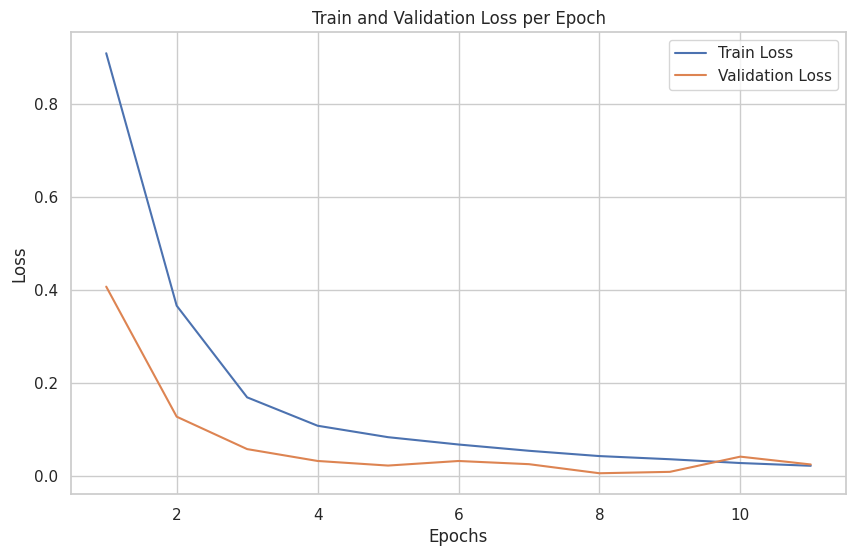

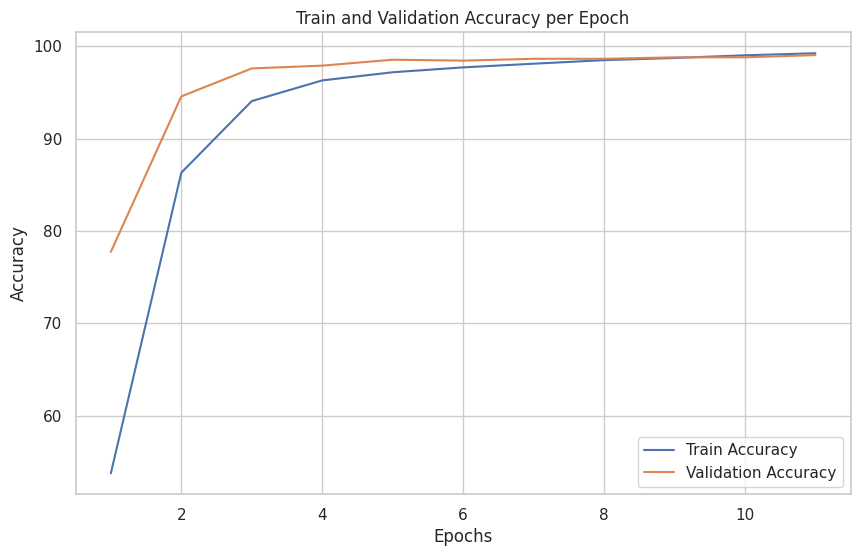

In [39]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

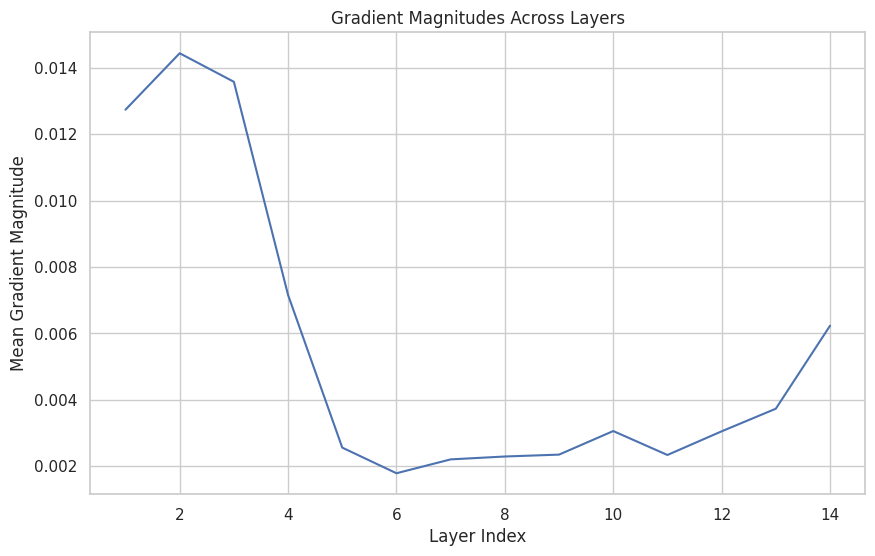

In [40]:
utils.plot_gradient(model)

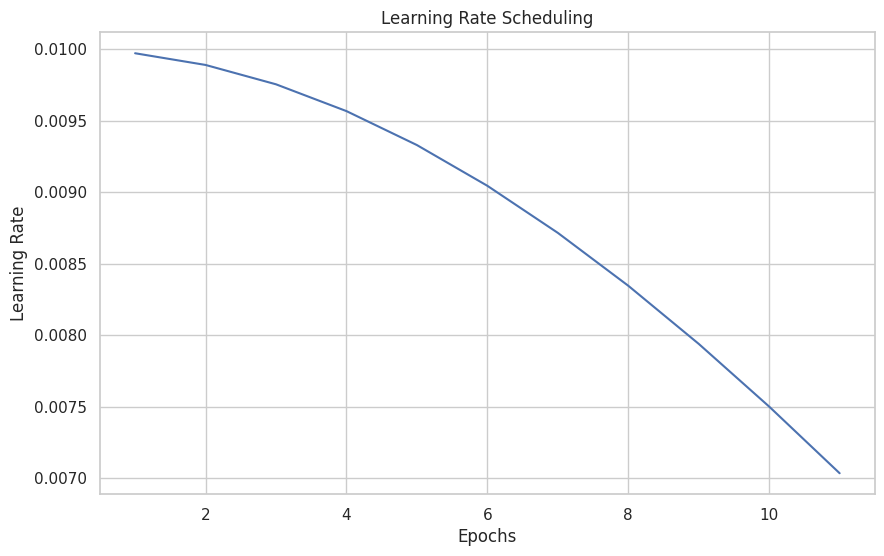

In [41]:
utils.plot_lr_scheduler(learning_rates)

In [42]:
all_preds_test, all_labels_test, all_images_A_test, all_images_B_test = utils.inference_MLPvector(model, test_loader, device)
all_preds_val, all_labels_val, all_images_A_val, all_images_B_val = utils.inference_MLPvector(model, validation_loader, device)

36 previsioni errate trovate.


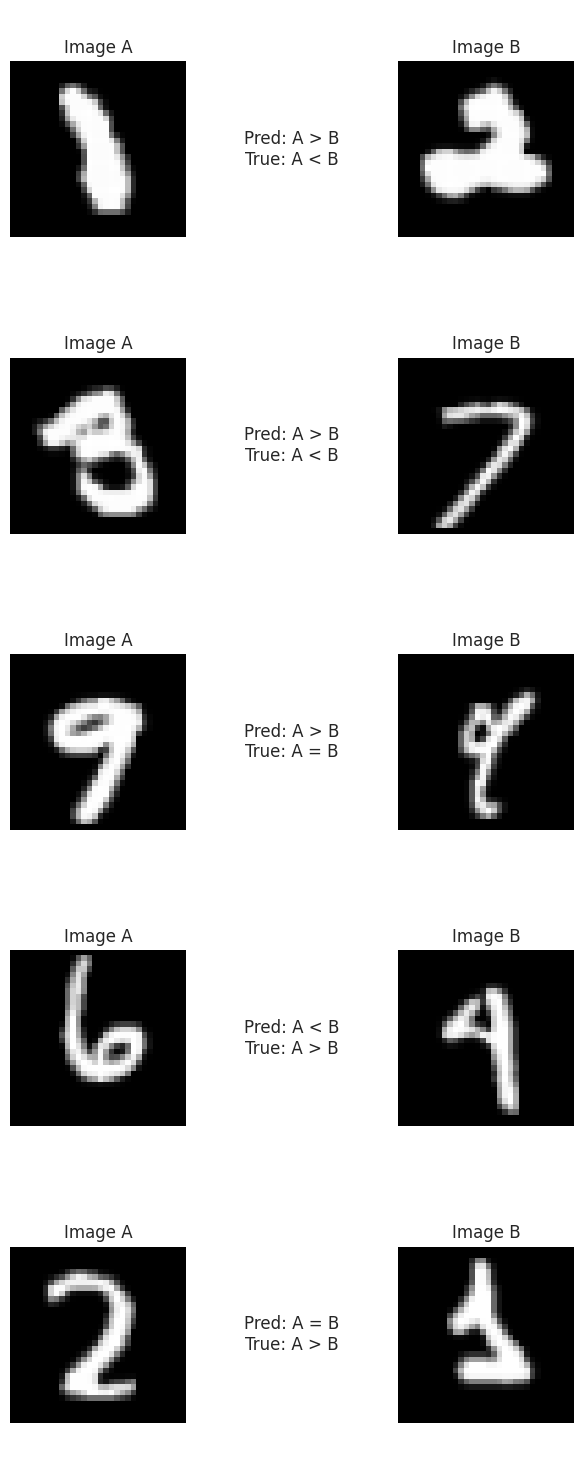

In [43]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_test', utils.show_incorrect_predictions_MLPvector(all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, 5))

68 previsioni errate trovate.


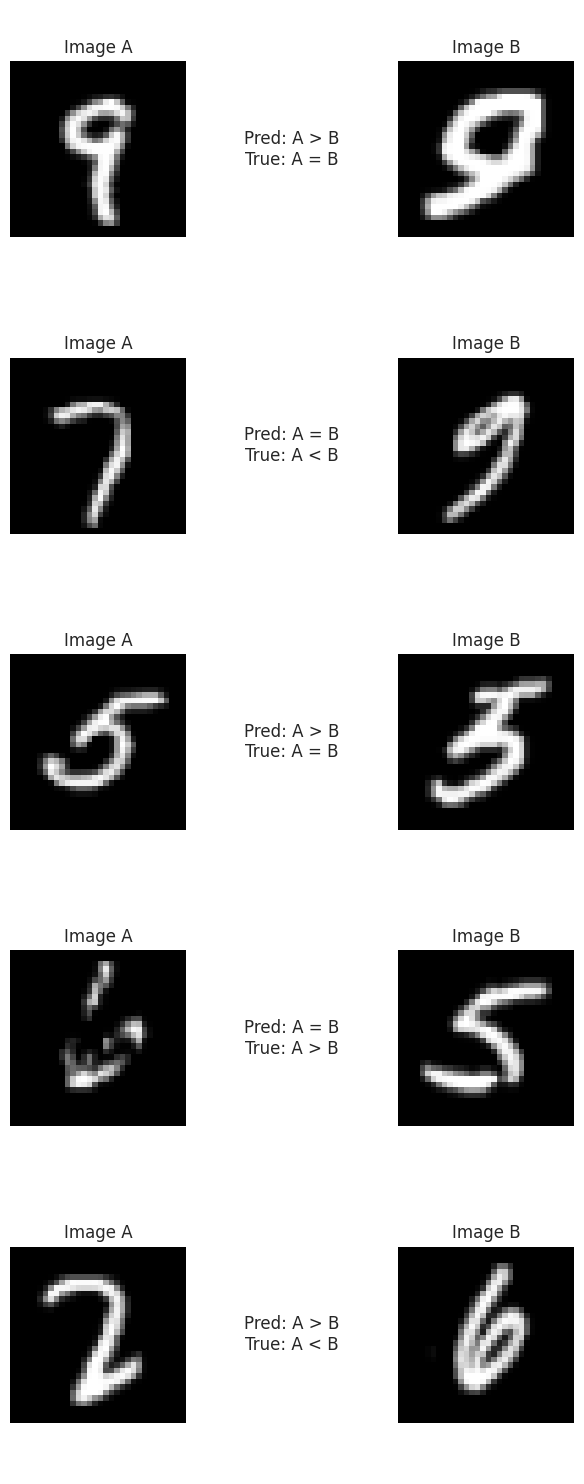

In [44]:
writer.add_figure('Incorrect_predictions_val', utils.show_incorrect_predictions_MLPvector(all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, 5))

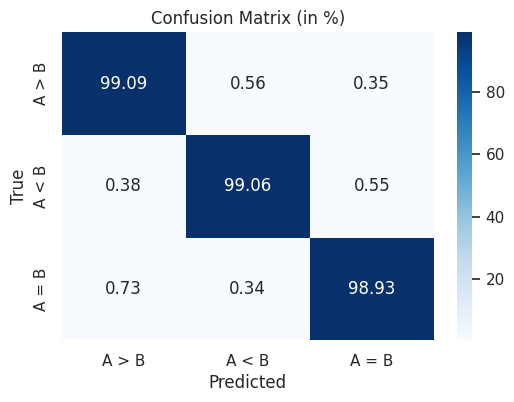

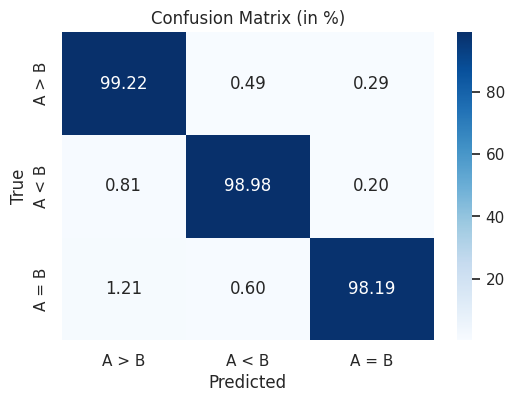

In [45]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(all_preds_val, all_labels_val))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(all_preds_test, all_labels_test))
#plot_confusion_matrix(model, test_loader, device)


In [46]:
# Stampa il report delle metriche
utils.classification_metrics(all_preds_test, all_labels_test)


              precision    recall  f1-score   support

       A > B       0.98      0.99      0.99      1021
       A < B       0.99      0.99      0.99       985
       A = B       0.99      0.98      0.99       994

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [47]:
# Funzione per salvare una copia del notebook
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    if OPTIMIZER == 'SGD':
        base_name = f"runMLPvector_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    elif OPTIMIZER == 'ADAM':
        base_name = f"runMLPvector_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    else:
        base_name = "runMLPvector"
    
    # Aggiungi estensione .ipynb
    new_notebook_name = f"{base_name}.ipynb"

    # Evita sovrascritture aggiungendo un numero incrementale se il file esiste
    counter = 1
    while os.path.exists(new_notebook_name):
        new_notebook_name = f"{base_name}_{counter}.ipynb"
        counter += 1

    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    
    print(f"Notebook saved as {new_notebook_name}")

# Specifica il nome del notebook attuale
save_notebook_copy('main_MLP_vector.ipynb')


Notebook saved as runMLPvector_BS=128_LR=0.01_MOM=0.9_EPOCHS=15_AUG=True_TRA=False_OPT=SGD.ipynb_1.ipynb


In [48]:
writer.close()